In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from funcs.models import model_ND
from scipy.optimize import minimize

## Heat input function

In [2]:
func_Q_in = lambda x: (1 + 0.5*np.sin(2*np.pi*x/(3600*12))) #

We are able to recover the desired heat capacity, thermal conductivity and initial temperature even with pretty bad intial guesses. However, need to ensure intial guesses are at least on the right order of magnitude.

## 2 Segments

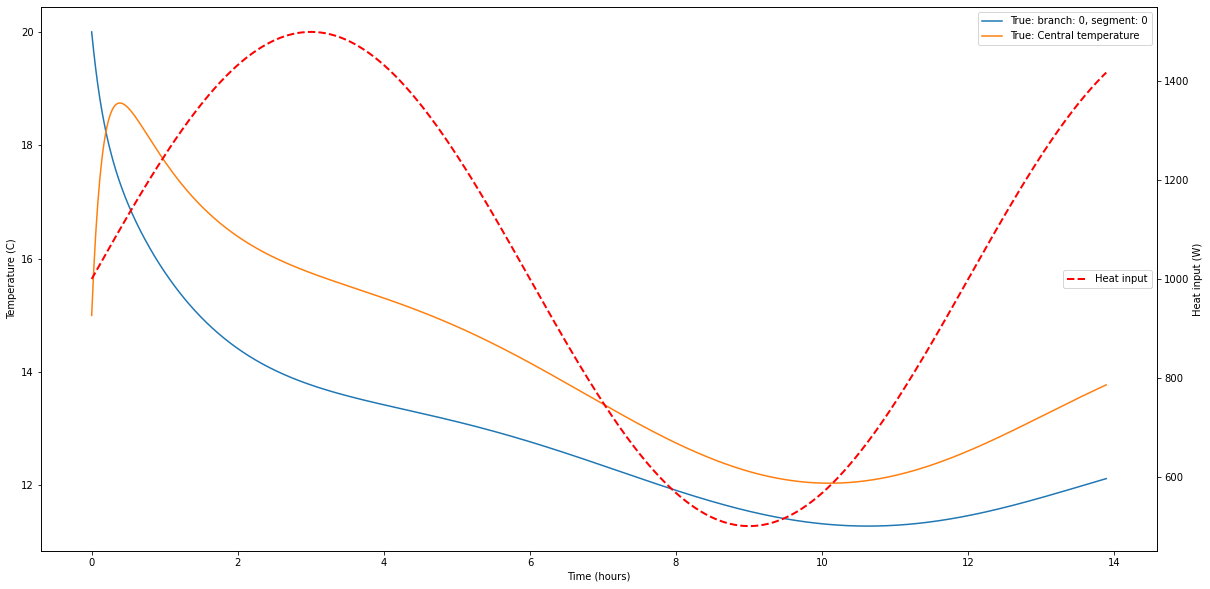

In [3]:
k = [800.0, 500.0]
c = [6e5, 2.5e6]
T = [15.0, 20.0]
true_params = np.array([*k, *c, *T])
T_out = 10
heatinput = 1000
iterations = 1000
# Initialise class with system parameters
sys_nd = model_ND('True', k, c, T, T_out, heatinput)

# Run simulation. This recreates simple_model.ipynb showing that our generalised model works.
times = np.linspace(0, 5e4, iterations+1)
Ts_true, Qs = sys_nd.run(times=times, func_Q_in=func_Q_in)
fig, ax = sys_nd.plot()

### Note on loss function
> The losses between model and true temperature of nodes are combined into a total loss, and this total loss is minimised. We might have better success by estimating parameters in individual segments first?

> We might be able to use the max rate of change of temperature of a particular node to provide initial guesses/bounds on thermal conductivity

In [4]:
def loss(params, method='mse'):
    
    # This loss function needs to be a lot faster as it will be called many times by scipy minimize
    
    T_out = 10
#     k_est, c_est, T_est = params
    k1, k2, c1, c2, T1, T2 = params
    
    k_est = np.array([k1,k2]).reshape(1,-1)
    c_est = np.array([c1,c2]).reshape(1,-1)
    T_est = np.array([T1,T2]).reshape(1,-1)
    
    times = np.linspace(0, 5e4, iterations+1)
    T_out = np.array(T_out).reshape(-1,1)
    Ts = np.empty(shape=(len(times), 1, 2))
    Ts[0] = T_est
    Q_in = 1000
    
    dtimes = np.diff(times)
    for i in range(len(times)-1):
        
        heat_flux = np.diff(np.hstack((T_est,T_out)))*k_est
        net_heat_flux = np.diff(heat_flux)
        
        # update non central nodes
        T_est[:, 1:] += ( net_heat_flux / c_est[:,1:] ) * dtimes[i]
        
        # update central node
        T_est[:, 0] += ( (heat_flux[:,0] + Q_in) / c_est[:,0] ).sum() * dtimes[i]
    
        Ts[i+1] = T_est

    Ts = np.transpose(Ts,axes=(1,2,0)) # New shape has (n_branches, n_segments, n_iterations)
    
    if method=='mse':
        # mean square error
        error = np.mean((Ts_true - Ts) ** 2)
    elif method=='mad':
        # mean absolute deviation
        error = np.mean(abs(Ts_true-Ts))
    elif method=='lae':
        # least absolute error
        error = np.sum(abs(Ts_true-Ts))
    elif method=='sse':
        # sum of squares error
        error = np.sum((Ts_true - Ts) ** 2)
    else:
        raise ValueError('Method not supported')
    
    return error

In [5]:
# Initial guesses for scipy.optimize.minimize
k0 = [900.0, 400.0]
c0 = [7e5, 1e6]
T0 = [16.0, 19.0]
initial_params = np.array([*k0, *c0, *T0])

# Testing different loss functions

#### Mean square error

	Initial			Estimated		Actual
k1:	900.00000		900.55599		800.00000
k2:	400.00000		405.90751		500.00000
c1:	700000.00000		700000.00753		600000.00000
c2:	1000000.00000		1000000.00697		2500000.00000
T1:	16.00000		16.62888		15.00000
T2:	19.00000		23.49980		20.00000
______________________________________________________
Percentage error:
k1:		12.57%		k2:		18.82%
c1:		16.67%		c2:		60.00%
T1_initial:	10.86%		T2_initial:	17.50%


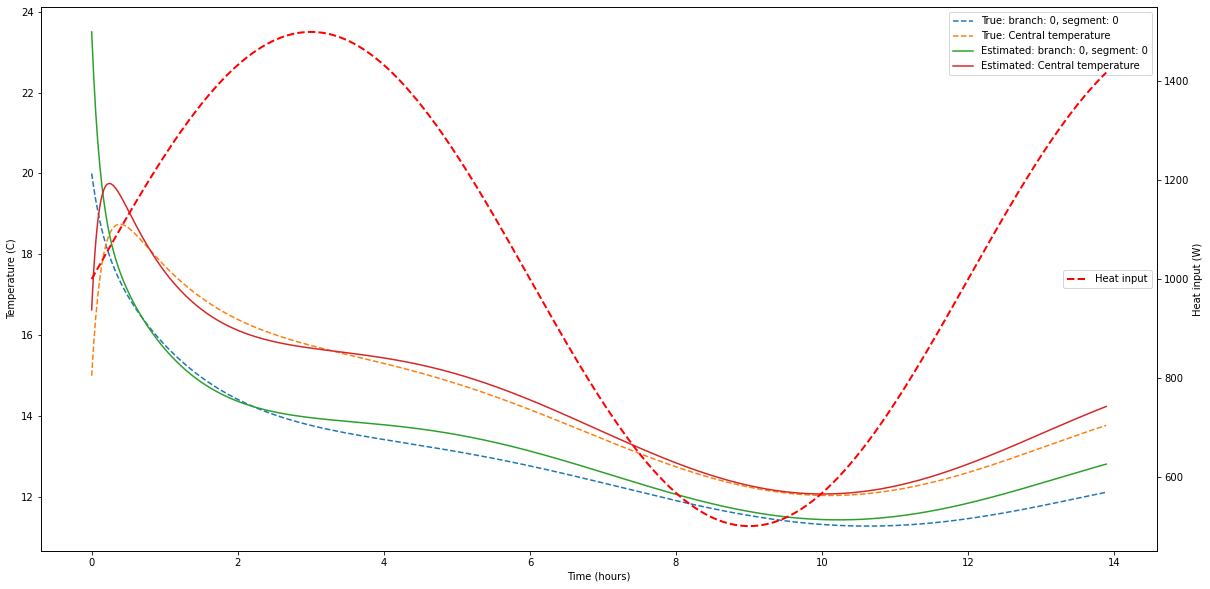

In [6]:
result = minimize(loss, x0=initial_params, args=('mse'), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
k_est, c_est, T_est = result['x'].reshape((3,2))
sys_est = model_ND('Estimated',k_est, c_est, T_est, T_out, heatinput)
Ts_est, Qs = sys_est.run(times=times, func_Q_in=func_Q_in)


fig, ax = sys_nd.plot(ls='--')
fig, ax= sys_est.plot(figax=(fig, ax), show_heating=False)

frac_error = abs((result['x'] - true_params)/true_params * 100)
print('\tInitial\t\t\tEstimated\t\tActual\nk1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nk2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}'.format(*np.ravel([initial_params,result['x'],true_params],'F')))
print('_'*54)
print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))

#### Mean absolute deviation

	Initial			Estimated		Actual
k1:	900.00000		900.02282		800.00000
k2:	400.00000		399.96716		500.00000
c1:	700000.00000		700000.00056		600000.00000
c2:	1000000.00000		1000000.00027		2500000.00000
T1:	16.00000		15.00000		15.00000
T2:	19.00000		25.54287		20.00000
______________________________________________________
Percentage error:
k1:		12.50%		k2:		20.01%
c1:		16.67%		c2:		60.00%
T1_initial:	0.00%		T2_initial:	27.71%


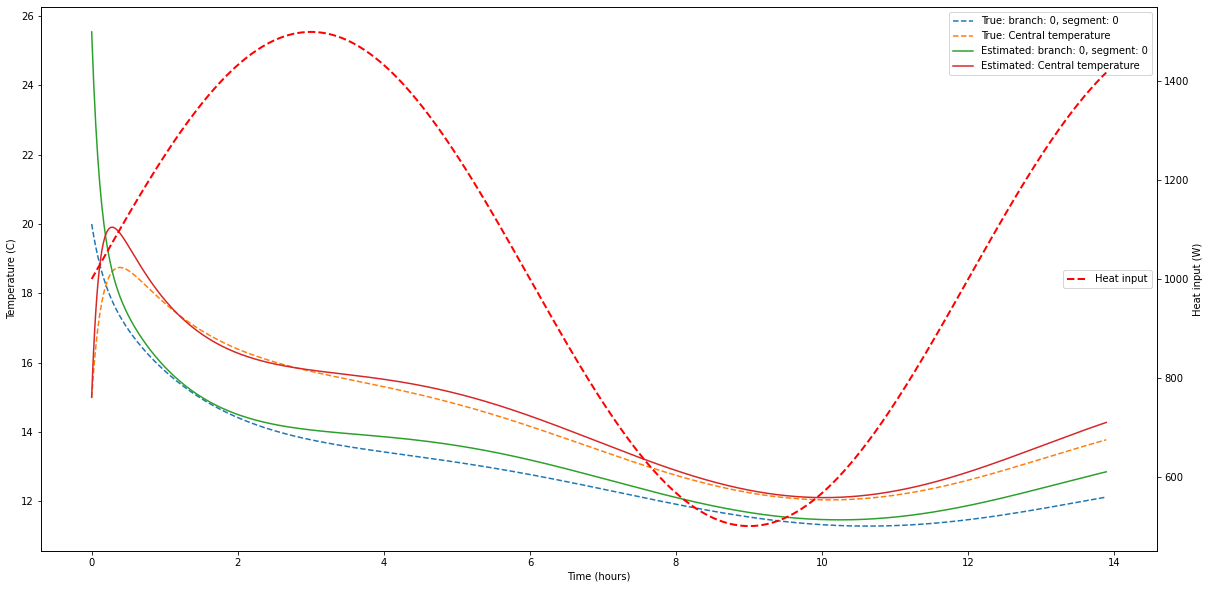

In [7]:
result = minimize(loss, x0=initial_params, args=('mad'), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
k_est, c_est, T_est = result['x'].reshape((3,2))
sys_est = model_ND('Estimated',k_est, c_est, T_est, T_out, heatinput)
Ts_est, Qs = sys_est.run(times=times, func_Q_in=func_Q_in)


fig, ax = sys_nd.plot(ls='--')
fig, ax= sys_est.plot(figax=(fig, ax), show_heating=False)

frac_error = abs((result['x'] - true_params)/true_params * 100)
print('\tInitial\t\t\tEstimated\t\tActual\nk1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nk2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}'.format(*np.ravel([initial_params,result['x'],true_params],'F')))
print('_'*54)
print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))

#### Sum of squares

	Initial			Estimated		Actual
k1:	900.00000		904.75417		800.00000
k2:	400.00000		405.54356		500.00000
c1:	700000.00000		700000.59859		600000.00000
c2:	1000000.00000		1000000.52396		2500000.00000
T1:	16.00000		16.62335		15.00000
T2:	19.00000		23.50073		20.00000
______________________________________________________
Percentage error:
k1:		13.09%		k2:		18.89%
c1:		16.67%		c2:		60.00%
T1_initial:	10.82%		T2_initial:	17.50%


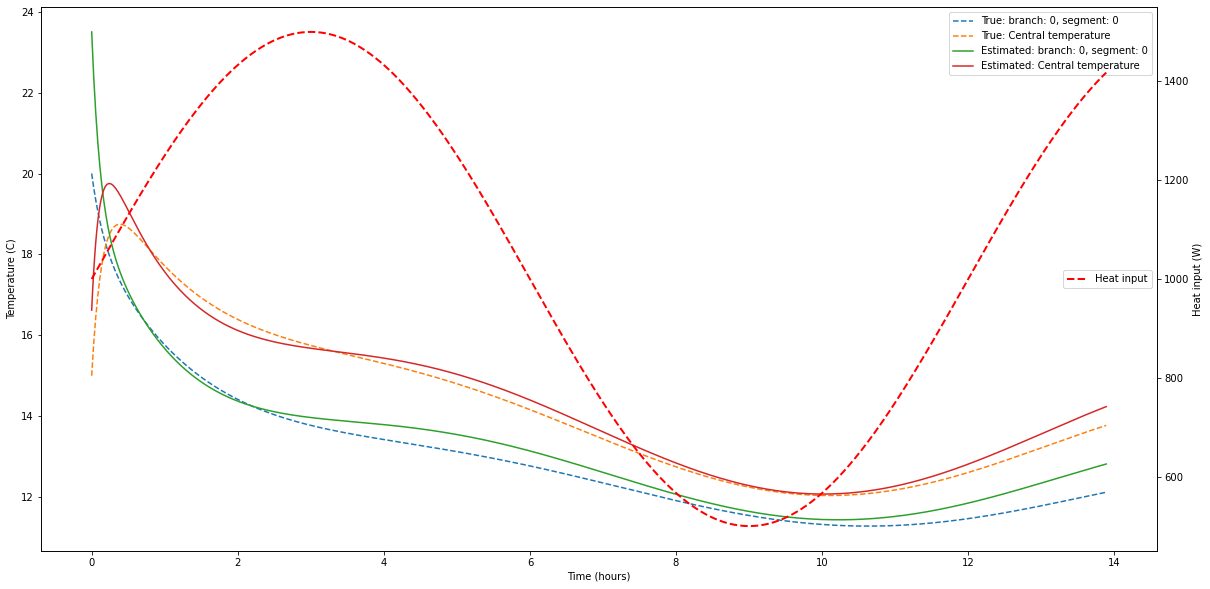

In [8]:
result = minimize(loss, x0=initial_params, args=('sse'), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
k_est, c_est, T_est = result['x'].reshape((3,2))
sys_est = model_ND('Estimated',k_est, c_est, T_est, T_out, heatinput)
Ts_est, Qs = sys_est.run(times=times, func_Q_in=func_Q_in)


fig, ax = sys_nd.plot(ls='--')
fig, ax= sys_est.plot(figax=(fig, ax), show_heating=False)

frac_error = abs((result['x'] - true_params)/true_params * 100)
print('\tInitial\t\t\tEstimated\t\tActual\nk1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nk2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}'.format(*np.ravel([initial_params,result['x'],true_params],'F')))
print('_'*54)
print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))

#### Least absolute error

	Initial			Estimated		Actual
k1:	900.00000		901.03504		800.00000
k2:	400.00000		395.84845		500.00000
c1:	700000.00000		700000.01248		600000.00000
c2:	1000000.00000		1000000.02078		2500000.00000
T1:	16.00000		15.00000		15.00000
T2:	19.00000		25.42338		20.00000
______________________________________________________
Percentage error:
k1:		12.63%		k2:		20.83%
c1:		16.67%		c2:		60.00%
T1_initial:	0.00%		T2_initial:	27.12%


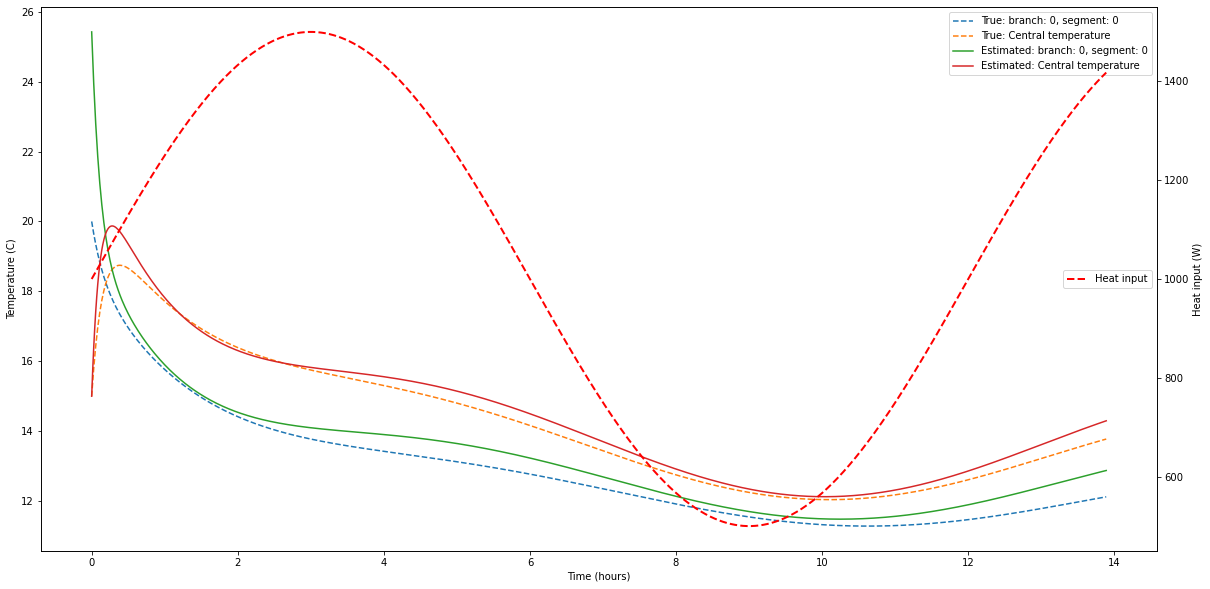

In [9]:
result = minimize(loss, x0=initial_params, args=('lae'), bounds=((1e2,1e3),(1e2,1e3),(1e5,1e6),(1e6,3e6),(10,30),(10,30)))
k_est, c_est, T_est = result['x'].reshape((3,2))
sys_est = model_ND('Estimated',k_est, c_est, T_est, T_out, heatinput)
Ts_est, Qs = sys_est.run(times=times, func_Q_in=func_Q_in)


fig, ax = sys_nd.plot(ls='--')
fig, ax= sys_est.plot(figax=(fig, ax), show_heating=False)

frac_error = abs((result['x'] - true_params)/true_params * 100)
print('\tInitial\t\t\tEstimated\t\tActual\nk1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nk2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nc2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT1:\t{:.5f}\t\t{:.5f}\t\t{:.5f}\nT2:\t{:.5f}\t\t{:.5f}\t\t{:.5f}'.format(*np.ravel([initial_params,result['x'],true_params],'F')))
print('_'*54)
print('Percentage error:\nk1:\t\t{:.2f}%\t\tk2:\t\t{:.2f}%\nc1:\t\t{:.2f}%\t\tc2:\t\t{:.2f}%\nT1_initial:\t{:.2f}%\t\tT2_initial:\t{:.2f}%'.format(*frac_error))